# Generating orientation dataset with halotools

In this notebook, we will be using the halo model-based intrinsic alignment model developed by Nick Van Alfen in Van Alfen et al. (in prep).



## Step I: Defining the halo model

In [2]:
# Uncomment to download the halo catalog
# from halotools.sim_manager import DownloadManager
# dman = DownloadManager()
# dman.download_processed_halo_table('bolshoi', 'rockstar', 0)

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar', redshift=0, version_name='halotools_v0p4')

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [4]:
from halotools.empirical_models import HodModelFactory

# define the central occupatoion model
from halotools.empirical_models import TrivialPhaseSpace, Zheng07Cens
cens_occ_model =  Zheng07Cens()
cens_prof_model = TrivialPhaseSpace()

# define the satellite occupation model
from halotools.empirical_models import Zheng07Sats
from halotools.empirical_models import NFWPhaseSpace, SubhaloPhaseSpace


sats_occ_model =  Zheng07Sats()
sats_prof_model = SubhaloPhaseSpace('satellites', np.logspace(10.5, 15.2, 15))

# define the alignment models
from halotools.empirical_models.ia_models.ia_model_components import CentralAlignment,\
    RadialSatelliteAlignment

central_orientation_model = CentralAlignment(central_alignment_strength=1.0)
satellite_orientation_model = RadialSatelliteAlignment(satellite_alignment_strength=1.0)

# combine model components
model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                 centrals_profile = cens_prof_model,
                                 satellites_occupation = sats_occ_model,
                                 satellites_profile = sats_prof_model,
                                 centrals_orientation = central_orientation_model,
                                 satellites_orientation = satellite_orientation_model,
                                 model_feature_calling_sequence = (
                                 'centrals_occupation',
                                 'centrals_profile',
                                 'satellites_occupation',
                                 'satellites_profile',
                                 'centrals_orientation',
                                 'satellites_orientation')
                                )

In [5]:
# populate mock catalog
model_instance.populate_mock(halocat)
print("number of galaxies: ", len(model_instance.mock.galaxy_table))

# For testing purposes, we are only going to keep halos with several satelittes
m = model_instance.mock.galaxy_table['halo_num_satellites'] > 5

galaxy_table = model_instance.mock.galaxy_table[m]

# Scaling mass 
galaxy_table['mass_scaled'] = log10(galaxy_table['halo_mvir_host_halo']) 
print("number of galaxies after filtering: ", len(galaxy_table))

number of galaxies:  74700
number of galaxies after filtering:  4478


/home/francois/repo/halotools/halotools/empirical_models/ia_models/ia_model_components.py:190: UserWarning: `central_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)
/home/francois/repo/halotools/halotools/empirical_models/ia_models/ia_model_components.py:520: UserWarning: `satellite_alignment_strength` key not detected in `table`.The value set in self.param_dict of this class will be used instead.
  warn(msg)


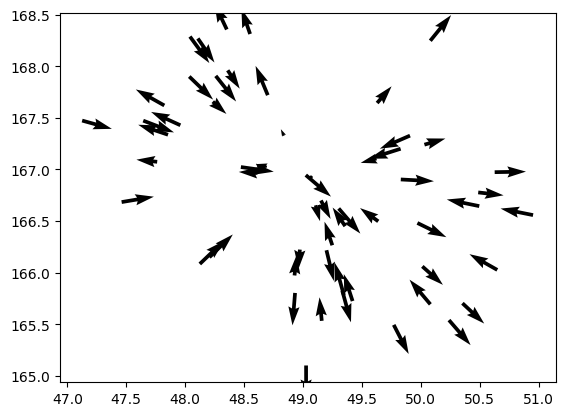

In [6]:
# Ok, very good, now, let's visualize a given halo
m = galaxy_table['halo_hostid'] == 3061174745
halo1 =  galaxy_table[m]
quiver(halo1['x'], halo1['y'],
       halo1['galaxy_axisA_x'], 
       halo1['galaxy_axisA_y'])

## Step II: Create batches of graphs from this catalog

In [14]:
import jax
import jax.numpy as jnp
from functools import partial
import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import optax

from deepghc.dataset import get_batch_fn

In [12]:
batch_fn = get_batch_fn(galaxy_table, 
                                vector_keys=['x', 'y', 'z', 
                                             'galaxy_axisA_x', 'galaxy_axisA_y', 'galaxy_axisA_z',
                                             'galaxy_axisB_x', 'galaxy_axisB_y', 'galaxy_axisB_z',
                                             'galaxy_axisC_x', 'galaxy_axisC_y', 'galaxy_axisC_z',],
                                scalar_keys=['mass_scaled'],
                                context_keys=['mass_scaled']
                               )

Precomputing dataset
Done


In [172]:
def EGCL(graph):
    """ Equivariant Graph Layer expects nodes with x, and h
    """
    x = graph.nodes['x']
    h = graph.nodes['h']
    n_features = h.shape[-1]

    d_ij = jnp.sqrt(jnp.sum((x[graph.senders] - x[graph.receivers])**2, axis=-1).reshape([-1, 1]))

    
    m_ij = hk.nets.MLP([n_features, n_features], activation=jax.nn.leaky_relu)(
            jnp.concatenate([h[graph.senders], 
                             h[graph.receivers],
                             d_ij**2, 
                             graph.edges.reshape([-1,1])] ,axis=-1)
            )
    # Attention weight
    e_ij = jax.nn.sigmoid(hk.Linear(1)(m_ij))

    # Updating latents
    new_h = jax.nn.leaky_relu(hk.Linear(n_features)(
            jnp.concatenate([
                h, 
                jraph.segment_sum( e_ij*m_ij, graph.receivers, num_segments=70)
            ], axis=-1)))
    new_h = h + hk.Linear(n_features)(new_h)

    # Updating vectors 
    d = (x[graph.senders][0] - x[graph.receivers][0])/(d_ij + 1)
    v_ij = hk.nets.MLP([n_features, n_features], activation=jax.nn.leaky_relu)(
            jnp.concatenate([h[graph.senders], 
                             h[graph.receivers],
                             d_ij**2, 
                             graph.edges.reshape([-1,1])], axis=-1)
            )
    v_ij = hk.Linear(1)(v_ij)
    x = x + jraph.segment_sum(d * v_ij, graph.receivers, num_segments=70)
    return graph._replace(nodes={'x': x,
                                 'h': h})

In [173]:
def network_definition(graph: jraph.GraphsTuple) -> jraph.ArrayTree:
    
    graph = graph._replace(nodes={'x': graph.nodes['vectors'][:,0,:] - graph.nodes['vectors'][0,0],
                                  'h': graph.nodes['scalars']})
    
    # Expending the dimensionality of hidden features
    graph = graph._replace(nodes={'x': graph.nodes['x'],
                                  'h': hk.Linear(16)(graph.nodes['h'])})
    
    graph = EGCL(graph)
    
    return graph

In [174]:
network = hk.without_apply_rng(hk.transform(network_definition))
batch_init = batch_fn(jax.random.PRNGKey(42))
#Removing the batch dimension
batch_init = jax.tree_map(lambda x:x[0], batch_init)
params = network.init(jax.random.PRNGKey(42), batch_init)

In [175]:
@jax.jit
@partial(jax.vmap, in_axes=[None, 0])
def prediction_loss(params, batch):
    decoded_nodes = network.apply(params, batch)
    
    loss = jnp.sum((decoded_nodes.nodes['x'])**2, axis=-1)
    loss = decoded_nodes._replace(nodes=loss)
    
    # We create a mask to not consider the output of useless nodes
    loss = jraph.zero_out_padding(loss)
    
    # We interpret the decoded nodes as a pair of logits for each node.
    return jnp.mean( loss.nodes )

@jax.jit
def update(params, opt_state, batch):
    l, g = jax.value_and_grad(lambda a,b:prediction_loss(a,b).mean())(params, batch)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state, l

In [176]:
opt_init, opt_update = optax.adam(1e-4)
opt_state = opt_init(params)
seed = jax.random.PRNGKey(0)
losses = []

In [177]:
params, opt_state, l = update(params, opt_state, batch)

In [178]:
for step in range(1000):
    seed, key = jax.random.split(seed)
    batch = batch_fn(key)
    params, opt_state, l = update(params, opt_state, batch)
    losses.append(l)

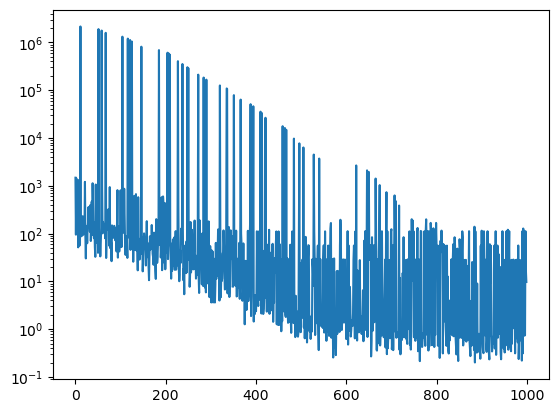

In [180]:
semilogy(losses)

In [183]:
res = jax.vmap(lambda x: network.apply(params, x))(batch)

In [185]:
res.nodes['x']

Array([[[-2.31736869e-01,  5.65838516e-01,  2.95872629e-01],
        [-1.08755618e-01,  2.65551686e-01,  1.38854980e-01],
        [-3.35753322e-01,  4.34861243e-01,  6.43166602e-02],
        ...,
        [-1.13764200e+01, -3.85879211e+01, -1.56303024e+02],
        [-1.13764200e+01, -3.85879211e+01, -1.56303024e+02],
        [-1.13764200e+01, -3.85879211e+01, -1.56303024e+02]],

       [[ 6.35961115e-01, -2.24413455e-01,  3.76245081e-01],
        [ 1.39312923e-01, -4.91597801e-02,  8.24198425e-02],
        [ 1.68558598e-01, -3.07581842e-01,  9.46173668e-02],
        ...,
        [-8.12590027e+01, -2.13846329e+02, -2.44630909e+01],
        [-8.12590027e+01, -2.13846329e+02, -2.44630909e+01],
        [-8.12590027e+01, -2.13846329e+02, -2.44630909e+01]],

       [[ 5.27875304e-01, -3.43914479e-01, -4.23103666e+00],
        [ 3.92784417e-01, -2.55901873e-01, -3.14825344e+00],
        [ 3.55323732e-01,  8.03653598e-01, -3.91297293e+00],
        ...,
        [-6.24422302e+01, -3.71014786e+01,